## Notebook to visualize demonstrations or runs stored in a directory 

In [1]:
import os
import copy
import time
import json
import shutil
import unittest
import subprocess
from pathlib import Path
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from scipy.spatial.transform import Rotation as R

from flow_control.runner import evaluate_control
from flow_control.servoing.module import ServoingModule
from flow_control.servoing.playback_env_servo import PlaybackEnvServo
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact, Layout
from tqdm import tqdm


%matplotlib inline

root_dir = "/home/argusm/Desktop/Demonstrations/single_part_with_selection_runs/2023-01-26"
# root_dir = "/home/argusm/Desktop/Demonstrations/multi_part_runs/2023-01-27"
root_dir = "/home/argusm/Desktop/Demonstrations/2023-01-24"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<IPython.core.display.Javascript object>


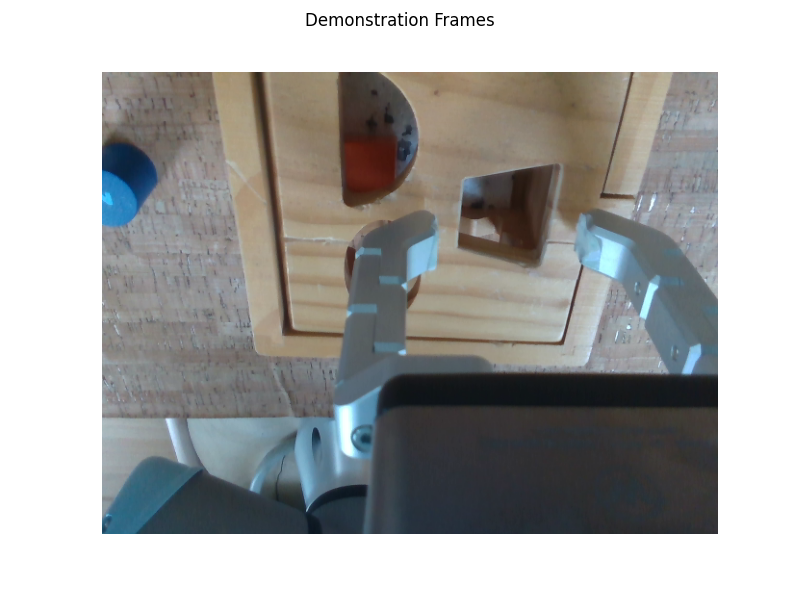

interactive(children=(IntSlider(value=0, description='demo_index', layout=Layout(width='70%'), max=29), IntSli…

<function __main__.update(demo_index, frame_index)>

In [2]:
recordings = sorted([os.path.join(root_dir, rec) for rec in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, rec))])
playbacks = []
import cv2

key_frames = {}

# Load the demonstration episodes
for idx, rec in enumerate(recordings):
    if os.path.exists(f"{rec}/frame_000000.npz"):
        try:
            playbacks.append(PlaybackEnvServo(rec, load='keep'))
            with open(f"{rec}/servo_keep.json", 'r') as f:
                skeep = json.load(f)
                key_frames[idx] = list([int(key) for key in skeep.keys()])
        except:
            print(f"Problem in recording: {rec}")

# Plot the demonstrations
%matplotlib notebook
fig, ax = plt.subplots(1,figsize=(8, 6))
fig.suptitle("Demonstration Frames")
ax.set_axis_off()
image_h = ax.imshow(playbacks[0].cam.get_image()[0])

def filter_demo(pb):
    return 1 if pb[-1].data['rew'] > 0 and np.atleast_1d(pb[-1].data['info'])[0]['object_selected'] == 2 else 0

def update(demo_index, frame_index):
    image = playbacks[demo_index][key_frames[demo_index][frame_index]].cam.get_image()[0]
    cv2.imwrite(f"image_{demo_index}_{frame_index}.jpg", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image_h.set_data(image)
    fig.canvas.draw_idle()
    fg_mask = playbacks[demo_index].get_fg_mask()
    if fg_mask is not None:
        print("percent fg:", np.mean(fg_mask)*100)
#     rew = filter_demo(playbacks[demo_index])
#     print(f"Reward: {rew}")

    print(recordings[demo_index])
    
    
slider_w = widgets.IntSlider(min=0, max=len(playbacks)-1, step=1, value=0,
                             layout=Layout(width='70%'))
slider_i = widgets.IntSlider(min=0, max=30, step=1, value=0,
                             layout=Layout(width='70%'))

interact(update, demo_index=slider_w, frame_index=slider_i)